## Installations & Imports

In [17]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/5a/5f/f4164295d6853ec6203bc728dea4da76a7145ba70482eab9e994d26e0e13/wordcloud-1.9.2-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/152.1 kB ? eta -:--:--
   -------- ------------------------------- 30.7/152.1 kB 1.3 MB/s eta 0:00:01
   ------------------------------------- -- 143.4/152.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 152.1/152.1 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
%pip install nltk

In [20]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import re
import numpy as np
from wordcloud import WordCloud
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

## Accessing Titles

In [5]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Fantastic Four altmetric-data-individual'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_name = 'Health and medical sciences'

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

# Open the Google Sheet
sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

# Get a list of article names from the Google Sheet
article_names = sheet.col_values(3)[1:]  # Article names are in the third column

In [6]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

## Exploration of Titles

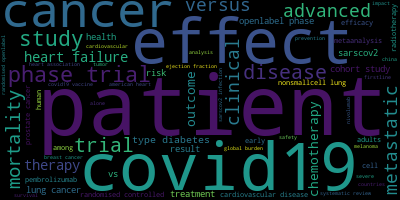

In [42]:
article_names_cleaned = np.vectorize(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))(article_names)

article_names_lower = np.vectorize(lambda x: x.lower())(article_names_cleaned)

all_titles = ','.join(list(article_names_lower))

wordcloud = WordCloud()

wordcloud.generate(all_titles)

wordcloud.to_image()

## Preprocessing Titles

In [ ]:
# Download NLTK data for stopwords and lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [41]:
# Define custom stopwords relevant to your analysis
custom_stopwords = set(["causes", "cause", "effect", "impact", "on", "of"])

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Tokenize the title
    words = word_tokenize(title_lower)

    # Remove stopwords and non-alphabetic tokens
    words = [word for word in words if word.isalpha() and word not in custom_stopwords]

    # Part-of-Speech tagging
    tagged_words = pos_tag(words)

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_words]

    # Join the words back into a processed title
    processed_title = ' '.join(lemmatized_words)

    return processed_title

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names_lower]
preprocessed_titles[0]

'the psychological quarantine and how to reduce it rapid review the evidence'

## LDA